In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers, models, optimizers
from keras.callbacks import EarlyStopping
from keras.applications import EfficientNetB4
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "dataset"
IMG_SIZE = (512, 512)
BATCH_SIZE = 32
VAL_SPLIT = 0.2
SEED = 123
EPOCHS = 20
PATIENCE = 3
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset="training",
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset="validation",
)
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

Found 409 files belonging to 2 classes.
Using 328 files for training.
Found 409 files belonging to 2 classes.
Using 81 files for validation.


In [4]:
base = EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_shape=(*IMG_SIZE, 3),
)
base.trainable = False

inputs = layers.Input(shape=(*IMG_SIZE, 3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = models.Model(inputs, outputs, name="oak_wilt_effb4")

model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "oak_wilt_effb4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 16, 16, 1792)   │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,793 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,675,616 (67.43 MB)

 Trainable params: 1,793 (7.00 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

In [5]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=PATIENCE,
    restore_best_weights=True,
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[early_stop],
    verbose=1,
)

Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.5115 - loss: 0.7115 - val_accuracy: 0.5432 - val_loss: 0.6896
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.5411 - loss: 0.6915 - val_accuracy: 0.6296 - val_loss: 0.6635
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.6391 - loss: 0.6561 - val_accuracy: 0.6543 - val_loss: 0.6401
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.6438 - loss: 0.6429 - val_accuracy: 0.7284 - val_loss: 0.6184
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.7104 - loss: 0.6100 - val_accuracy: 0.7284 - val_loss: 0.5976


In [6]:
base.trainable = True
for layer in base.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop],
)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.5528 - loss: 0.6762 - val_accuracy: 0.7654 - val_loss: 0.5767
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.6772 - loss: 0.6372 - val_accuracy: 0.8025 - val_loss: 0.5564
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.7558 - loss: 0.5817 - val_accuracy: 0.8272 - val_loss: 0.5357
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.8131 - loss: 0.5425 - val_accuracy: 0.8395 - val_loss: 0.5159
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.8206 - loss: 0.5209 - val_accuracy: 0.8519 - val_loss: 0.4962
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.8378 - loss: 0.5038 - val_accuracy: 0.8765 - val_loss: 0.4755
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 49s 5s/step - accuracy: 0.9198 - loss: 0.4444 - val_accuracy: 0.8765 - val_loss: 0.4571
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - accuracy: 0.8891 - loss: 0.4444 - val_accuracy: 0.8889 - val_loss:

In [7]:
out_path = "oak_wilt_effb4.keras"
model.save(out_path)
print(f"\nModel saved to: {out_path}")


Model saved to: oak_wilt_effb4.keras


# Analysis

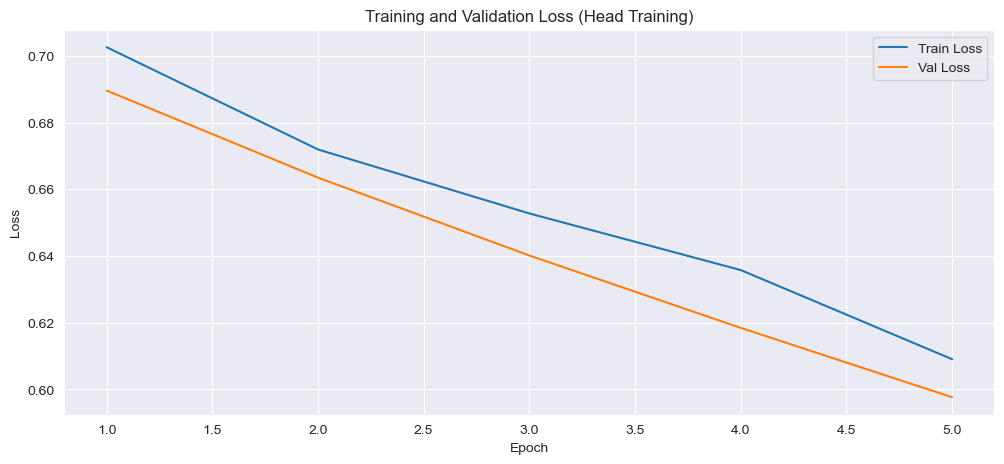

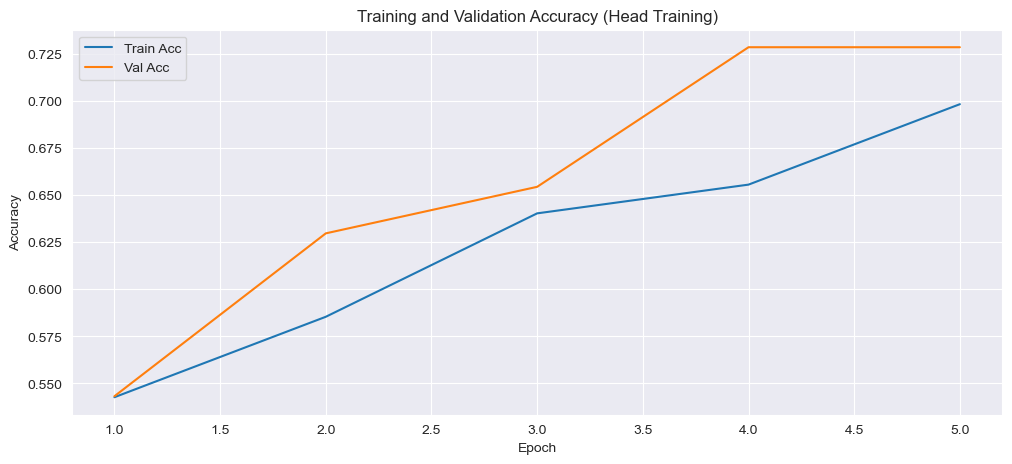

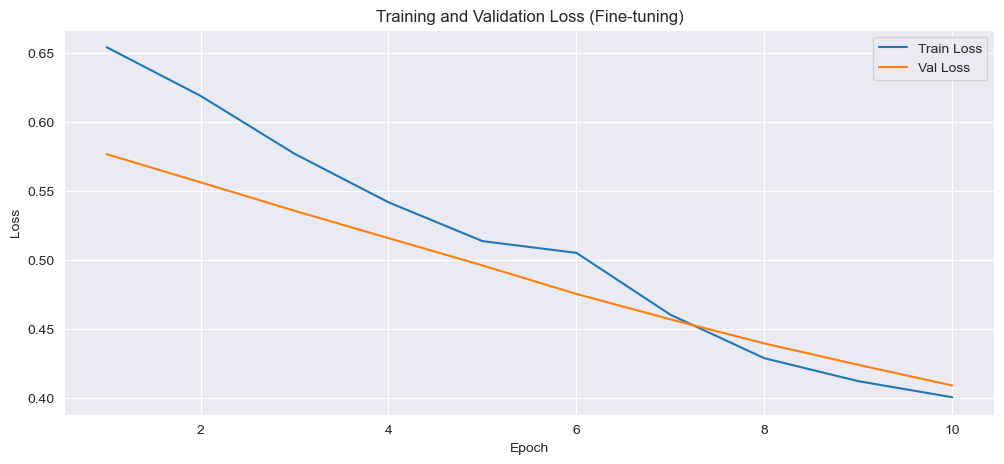

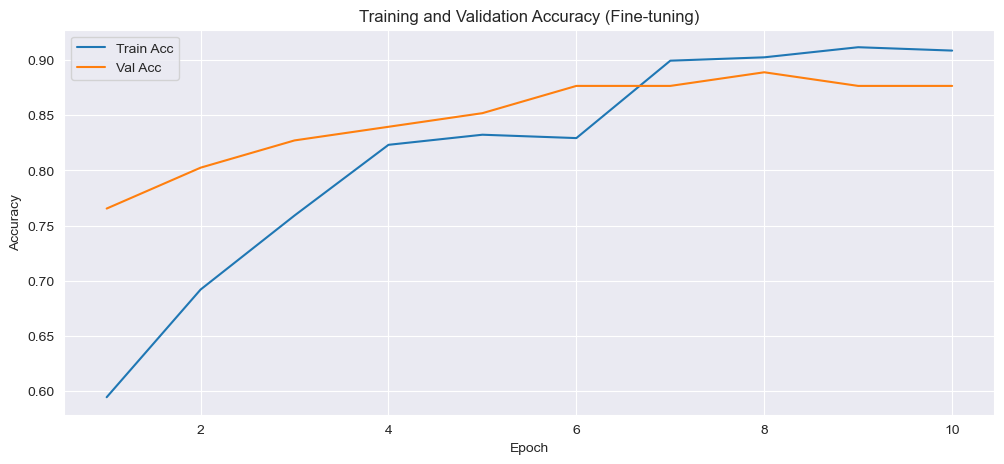

2025-07-14 00:20:59.748387: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step

Classification Report:
               precision    recall  f1-score   support

     healthy       0.49      0.59      0.53        39
   unhealthy       0.53      0.43      0.47        42

    accuracy                           0.51        81
   macro avg       0.51      0.51      0.50        81
weighted avg       0.51      0.51      0.50        81


Confusion Matrix:
 [[23 16]
 [24 18]]


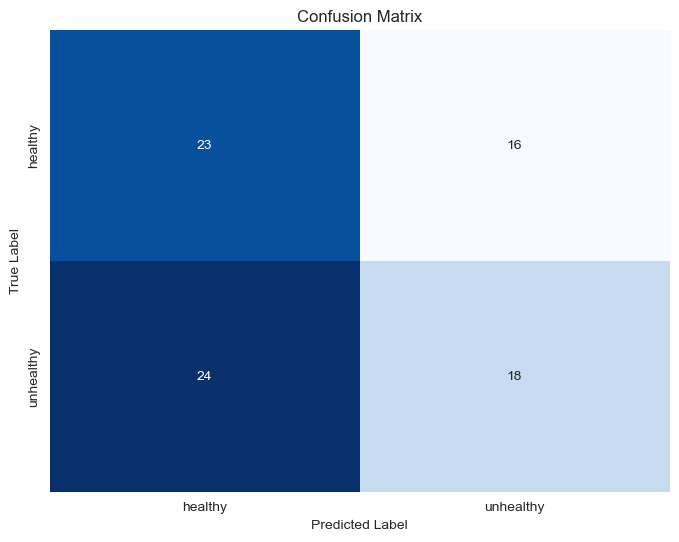

In [8]:
def plot_history(history, title_suffix=""):
    df_hist = pd.DataFrame(history.history)
    df_hist['epoch'] = df_hist.index + 1

    plt.figure(figsize=(12,5))
    sns.lineplot(x='epoch', y='loss', data=df_hist, label='Train Loss')
    sns.lineplot(x='epoch', y='val_loss', data=df_hist, label='Val Loss')
    plt.title(f'Training and Validation Loss{title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12,5))
    sns.lineplot(x='epoch', y='accuracy', data=df_hist, label='Train Acc')
    sns.lineplot(x='epoch', y='val_accuracy', data=df_hist, label='Val Acc')
    plt.title(f'Training and Validation Accuracy{title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot histories
plot_history(history, " (Head Training)")
plot_history(history_fine, " (Fine-tuning)")

# Evaluate on validation set
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0).flatten()
y_pred_proba = model.predict(val_ds).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

# Classification report
cr = classification_report(y_true, y_pred, target_names=["healthy", "unhealthy"])
print("\nClassification Report:\n", cr)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["healthy","unhealthy"], yticklabels=["healthy","unhealthy"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()